<img src="http://landlab.github.io/assets/Landlab-logo.png"
style="float:left;width:150px;padding:0px">  

<br /> 

# Use Depth to Groundwater to force Landlab shallow landslide model <br /> 
### You will explore how to reuse model code and data in a subregion within a larger region where the model was developed 
* Load data from a regional Landlab landslide model (Strauch et al., 2018) developed for the North Cascades National Park, WA USA, published on HydroShare. <br />
* Define a geographic subset (Thunder Creek watershed) within the study region.
* Explore landslide probability sensitivity to fire by adjusting the cohesion parameter for Thunder Creek.
* Save results to a new HydroShare resource.  <br />

The shallow landslide model you will is based on a spatially distributed Monte Carlo solution of the infinite slope stability model. Detailes of the model and the study site are described in Strauch et al. (2018). Please see the end of this Notebook for Acknowledgements and Citation information. 

 <br /> <img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:120px;padding:10px">   

## To run this notebook:

Click in each shaded cell below and "shift + enter" to run each code block. Alternatively, you can run groups of cells by clicking "Cell" on the menu above and selecting your run options from the pull-down menu. This is also where you can clear outputs from previous runs.

If an error occurs, click on *Kernal* and *Restart and Clear Outputs* in the menu above.

## 1. Introduction

** 1.1 Infinite Slope Factor of Safety Equation **

This equation predicts the ratio of stabilizing to destabilizing forces on a hillslope plane. The properties are assumed to represent an infinte plane, neglecting the boundary conditions around the landslide location. When FS<1, the slope is instable.

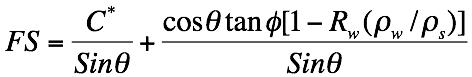

## 2.0 Data Science & Cyberinfrastructure Methods

Update or add libraries that are not installed on the CUAHSI JupyterHub server.  At the time of publication, the Landlab library was dependent on a different numpy library than installed in the software environment. The code block below was added as an example of how to update a library to a new version and restart the notebook kernel.  If this update is not needed, comment with a <#>.  If other updates are needed, add them below.

In [1]:
# comment this out if this update is not needed
#!conda update -y numpy
#from IPython.display import display_html
#display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

### 2.1 Data Science Methods

### 2.1.1 Import Landlab components, functions for importing data, plotting tools, and HydroShare utilities

To run this notebook, we must import several libraries.
The hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading. and creation. Additional libraries support the functions of Landlab.   The CUAHSI JupyterHub server provides many Python packages and libraries, but to add additional libraries to your personal user space, use the cell below.  To request an Installation to the server, visit https://github.com/hydroshare/hydroshare-jupyterhub, create a New Issue, and add the label 'Installation Request'. 

### 2.1.2 Import Landlab libraries in development, Python libraries and Landlab 2.1.1 functions

In [2]:
#import landlab
import landslide_unitgrid as lgd
from landlab.io.netcdf import read_netcdf   
import xarray as xr

In [3]:
#Import standard Python utilities for calculating and plotting
import six 
import os
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pickle as pickle
from datetime import datetime, timedelta
#import geopandas as gpd

# Import Landlab libraries
from landlab import imshow_grid_at_node
from landlab.io import read_esri_ascii
from landlab.io import write_esri_ascii
from landlab.plot import imshow_grid
# Import Landlab Landslide componnent libraries
from landlab.components.landslides import LandslideProbability

#Import utilities for importing and exporting to HydroShare
#from hstools import hydroshare

# Import general tools
import time
from collections import defaultdict
st = time.time()
%matplotlib inline

### 2.1.3 Connection with HydroShare
After importing libraires, we now establish a secure connection with HydroShare by instantiating the hydroshare class that is defined within hs_utils. In addition to connecting with HydroShare, this command also sets and prints environment variables for several parameters that will be useful for saving work back to HydroShare.

In [4]:
#hs=hydroshare.hydroshare()
#homedir=os.getcwd()
#homedir = os.path.join('/home/jovyan/work/notebooks/data', str(homeresid),str(homeresid),'data/contents/')
#print('This is a basic Unix folder structure.')
#print('Data will be loaded from and saved to:'+homedir)
#370c288b61b84794b847ef85c4dd4ffb

If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon in upper rigth corner to see a File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

### 2.2. Cyberinfrastructure methods
Strauch et al (2018) pre-processed the data for the North Cascades National Park Complex case study and is on HydroShare as [Regional landslide hazard using Landlab - NOCA Data](https://www.hydroshare.org/resource/a5b52c0e1493401a815f4e77b09d352b/). Here the first task is find this resource on Hydrohsare. We will click on the link to see the published data repository on HydroShare and collect the resource ID of the data. The resource ID can be found in the "How to cite" box, and it will be the series of numbers and letters following "hs.". Here's the copied resource: http://dx.doi.org/10.4211/hs.a5b52c0e1493401a815f4e77b09d352b citation. Now we copy this ID and introduce it as "Data_ResourceID=" in the code below. 

#### 2.2.1 Set DEM data download variable name
To learn more about this data visit [Regional landslide hazard using Landlab - NOCA Data](https://www.hydroshare.org/resource/a5b52c0e1493401a815f4e77b09d352b/)

In [5]:
!pwd

/home/jovyan/work/Downloads/370c288b61b84794b847ef85c4dd4ffb/370c288b61b84794b847ef85c4dd4ffb/data/contents


#### 2.2.2 Download Data
We will execute the next cell to download data from HydroShare iRods database to your personal user space - this may take a few minutes.

This only needs to happen one time to transfer data from HydroShare storage to the JupyterHub server workspace. 

In [6]:
#hs.getResourceFromHydroShare(Data_ResourceID)  #SCL Slippery Future Data 01b486f301864828ba2cd9ab7ac77c4e

In [9]:
homedir_folder = '/home/jovyan/work/Downloads/370c288b61b84794b847ef85c4dd4ffb/370c288b61b84794b847ef85c4dd4ffb/data/contents'

hydroshare_folder = '/home/jovyan/work/Downloads/01b486f301864828ba2cd9ab7ac77c4e/01b486f301864828ba2cd9ab7ac77c4e/data/contents'
#C:/Users/cband/hydroshare/01b486f301864828ba2cd9ab7ac77c4e/01b486f301864828ba2cd9ab7ac77c4e/data/contents

In [10]:
#Data_ResourceID='a5b52c0e1493401a815f4e77b09d352b'
#data_folder = os.path.join(os.getcwd(), hs.getContentPath(Data_ResourceID), 'Data files')
data_folder = hydroshare_folder +'/ASCII_Files'
print('This HydroShare resource has been downloaded to: %s' % data_folder)

landslide_folder =  hydroshare_folder +'/ASCII_Files/'
print('This HydroShare resource with Landlab model input GIS data has just been downloaded has been downloaded to: %s' % landslide_folder)

dhsvm_folder =  hydroshare_folder +'/DHSVM'
print('This HydroShare resource with Hydrology Model data  has been downloaded to: %s' % dhsvm_folder)

dates_folder = hydroshare_folder +'/DHSVM/dates_max_sat_skagit'
print('This HydroShare resource with storm dates printed from the hydrology model has been downloaded to: %s' % dates_folder)

netcdf_folder = homedir_folder +'/netcdf/'
print('The netcdf inputs/outputs is in: %s' % netcdf_folder)
#!mkdir netcdf_folder

This HydroShare resource has been downloaded to: /home/jovyan/work/Downloads/01b486f301864828ba2cd9ab7ac77c4e/01b486f301864828ba2cd9ab7ac77c4e/data/contents/ASCII_Files
This HydroShare resource with Landlab model input GIS data has just been downloaded has been downloaded to: /home/jovyan/work/Downloads/01b486f301864828ba2cd9ab7ac77c4e/01b486f301864828ba2cd9ab7ac77c4e/data/contents/ASCII_Files/
This HydroShare resource with Hydrology Model data  has been downloaded to: /home/jovyan/work/Downloads/01b486f301864828ba2cd9ab7ac77c4e/01b486f301864828ba2cd9ab7ac77c4e/data/contents/DHSVM
This HydroShare resource with storm dates printed from the hydrology model has been downloaded to: /home/jovyan/work/Downloads/01b486f301864828ba2cd9ab7ac77c4e/01b486f301864828ba2cd9ab7ac77c4e/data/contents/DHSVM/dates_max_sat_skagit
The netcdf inputs/outputs is in: /home/jovyan/work/Downloads/370c288b61b84794b847ef85c4dd4ffb/370c288b61b84794b847ef85c4dd4ffb/data/contents/netcdf/


In [11]:
# 1. Dates for printing output for Hydrology model; DHSVM; 150 m depth to groundwater
dates_filename = 'export_historic_dates'
dates_file = '{}/{}'.format(dates_folder, dates_filename)

# 2. Hydrology model; DHSVM; 150 m depth to groundwater
dhsvm_filename='output_SCLlandslide_historic/Map.Soil.TableDepth.asc'
dhsvm_file = '{}/{}'.format(dhsvm_folder, dhsvm_filename)

# 3. Spatial domain for hydrology model (Skagit Hydrology Model DHSVM domain; 150 m grid cell)
hydro_dem = '{}/{}'.format(data_folder, "demsrtm150_1000.txt")

# 4. Spatial domain for landslide model (Seattle City Light Landslide Model Domain; 30 m grid cell)
#url_mask = '{}/{}'.format(data_folder, "sclmask09_301.tif")


#### Load  spatial landslide model inputs from ASCII textfile (ArcGIS raster conversion) into Landlab grid

Create Landlab RasterModelGrid using DEM grid with elevation - this takes approximately 60 sec for the North Cascades National Park (NOCA). 

In [12]:
!ls netcdf/*

netcdf/DHSVM_elevationNETCDF4.nc
netcdf/SCL_elevationNETCDF3_64BIT.nc
netcdf/SCL_elevationNETCDF4.nc
netcdf/SCL_elevation+obs+lc+fire+gl+NETCDF3_64BIT.nc
netcdf/SCL_elevation+obs+lc+fire+gl+NETCDF4.nc


## Make a netcdf template 

@gantian127
[ueb-analysis/xmrg_to_netcdf_3.py](https://github.com/gantian127/ueb-analysis/blob/bd716ac9062c18e07a788d7301a0ad31fd3cf64e/xmrg_to_netcdf_3.py)
@gantian127
Latest commit bd716ac on Oct 29, 2018
History:  1 contributor
  
This is used for the use case in netCDF paper. It converts the RDHM xmrg output as one netCDF file for sharing.
step3: get tif data and write as netCDF file
steps: (17min/22yr)
- get tif file and create netCDF template
- read all the tif file and create as numpy array
- add numpy array in the netCDF template
- add time dimension in the netCDF template


In [20]:
import sys
!{sys.executable} -m pip install pycrs
import pycrs

  Using cached PyCRS-1.0.2.tar.gz (36 kB)
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32681 sha256=fc97aadd88aa83d4a1bb070e0bd596a8744af7e06d808acc79c027e265f348e8
  Stored in directory: /home/jovyan/.cache/pip/wheels/c1/e9/f3/19ecf82bebc5cdaba5c2a83f673f7b9b09c26fbc9b57534a2e
Successfully built pycrs


In [17]:
import os
import subprocess
import shlex
import gdalnumeric
import netCDF4
import numpy as np
import pandas as pd
import xarray as xr

In [41]:
crs = pycrs.parse.from_epsg_code(4326)
crs?
crs.unit

AttributeError: 'GeogCS' object has no attribute 'unit'

In [19]:
# step1: user settings #####################################################
watershed = 'SCL'
folder_name = '{}_landlabnc_to_HSnetCDF'.format(watershed)
result_folder = os.path.join(os.getcwd(), folder_name)
nc_df_path = os.path.join(netcdf_folder, 'SCL_elevationNETCDF4.nc')
da_mask = xr.open_dataset(nc_df_path)
da_mask

nc_flip = False
flip_axis = 1

start_date = '1988-10-1'
end_date = '2010-06-30'

In [3]:
# step2: get netcdf data #######################################################
tif_df = pd.read_csv(tif_df_path, header=0, index_col=0)
tif_df.index = tif_df.index.to_datetime()
if start_date and end_date:
    tif_df = tif_df[(tif_df.index>=start_date) & (tif_df.index<end_date)]

for var in tif_df.columns:
    var_tif_folder = os.path.join(result_folder, 'tif_folder_{}'.format(var))
    var_stack_list = []

    if os.path.isdir(var_tif_folder):
        for time in tif_df.index:
            tif_path = os.path.join(var_tif_folder, tif_df[var].ix[time])
            tif_array = gdalnumeric.LoadFile(tif_path)
            var_stack_list.append(tif_array)

        # create tif array
        var_tif_array = np.stack(var_stack_list)
        if tif_flip:
            var_tif_array = np.flip(var_tif_array, axis=flip_axis)  # this is aimed to make the tif array y axis same as netcdf array y axis
        np.save(os.path.join(result_folder, '{}_tif_array'.format(var)), var_tif_array)

        # create template nc file
        nc_tem_path = os.path.join(result_folder,'{}_temp.nc'.format(var))
        cmd = "gdal_translate -of netCDF -co 'FORMAT=NC4' {} {}".format(tif_path, nc_tem_path)
        subprocess.Popen(shlex.split(cmd)).wait()

    else:
        print 'No folder for {}'.format(var_tif_folder)

# step3: create netCDF file ##############################################################
for var in tif_df.columns:
    nc_tem_path = os.path.join(result_folder, '{}_temp.nc'.format(var))
    root = netCDF4.Dataset(nc_tem_path, 'a')

    # define time variable
    time_dim = root.createDimension("time", None)
    time_var = root.createVariable("time", "f4", ("time",))
    time_var.units = 'hours since {} 00:00:00.0 UTC'.format(tif_df.index[0].strftime('%Y-%m-%d'))
    time_var.calendar = 'standard'
    time_dates = tif_df.index.tolist() # use netcdf string conversion function
    time_var[:] = netCDF4.date2num(time_dates, units=time_var.units, calendar=time_var.calendar)

    # define data variable
    band = root.variables['Band1']
    band_data = band[:]
    mask = np.ma.getmask(band_data)
    grid_mapping = band.grid_mapping
    fill_value = band_data.get_fill_value()

    # remember to specify fill value otherwise will show strange data, the data type is 32 float.
    nc_var = root.createVariable(var, 'f4', ("time", "y", "x"), fill_value=fill_value)
    nc_var.grid_mapping = grid_mapping
    tif_array_data = np.load(os.path.join(result_folder, '{}_tif_array.npy'.format(var)))
    tif_array_mask = np.repeat(mask[np.newaxis, :, :], tif_array_data.shape[0], axis=0)
    nc_var_data = np.ma.masked_array(tif_array_data, mask=tif_array_mask)
    nc_var[:] = nc_var_data

    # # define global attributes
    # root.title = 'Model simulation of snow water equivalent in '
    # root.abstract = ''
    # root.creator_name = 'Tian Gan'
    # root.summary = ''
    # root.keywords = 'snow water equivalent '
    root.close()

    # remove band variable
    nc_path = os.path.join(result_folder, '{}_netcdf.nc'.format(var))
    nco_cmd = 'ncks -x -v Band1 {} {}'.format(nc_tem_path, nc_path)
    subprocess.Popen(shlex.split(nco_cmd)).wait()

print 'xmrg to netCDF is done!'

© 2020 GitHub, Inc.
Terms
Privacy
Security
Status
Help
Contact GitHub
Pricing
API
Training
Blog
About


SyntaxError: invalid syntax (<ipython-input-3-bc5362989e4d>, line 41)

## 2.6 Use DHSVM.Map output for Depth to Water Table to calculate landslide probability

## Elevation Domain Data Processing

Markdown on xarray Needed  da=data array

In [11]:
!pwd

/home/jovyan/work/Downloads/370c288b61b84794b847ef85c4dd4ffb/370c288b61b84794b847ef85c4dd4ffb/data/contents


In [12]:
#from landlab.io.netcdf import write_raster_netcdf
#data_folder+'/demsrtm150_1000.txt'
#(grid_150, z) = read_esri_ascii(data_folder+'/demsrtm150_1000.txt',name='topographic__elevation')
#print(grid_150.at_node.keys())
#print(grid_150.shape)
#grid_150.set_nodata_nodes_to_closed(z, -9999.0)
#write_raster_netcdf("DHSVM_elevationNETCDF4.nc", grid_150, format="NETCDF4", names=["topographic__elevation"])

In [13]:
da_mask = xr.open_dataset(netcdf_folder +'SCL_elevationNETCDF4.nc')
da_mask

<xarray.Dataset>
Dimensions:                 (ni: 2725, nj: 2720, nt: 1)
Dimensions without coordinates: ni, nj, nt
Data variables:
    y                       (nj) float64 ...
    x                       (ni) float64 ...
    topographic__elevation  (nt, nj, ni) float64 ...

In [14]:
da = xr.open_dataset(netcdf_folder +'DHSVM_elevationNETCDF4.nc')
da

<xarray.Dataset>
Dimensions:                 (ni: 916, nj: 1020, nt: 1)
Dimensions without coordinates: ni, nj, nt
Data variables:
    y                       (nj) float64 ...
    x                       (ni) float64 ...
    topographic__elevation  (nt, nj, ni) float64 ...

In [15]:
#get size of y
temp_y = da.y.values
size_y = temp_y.size
size_y

1020

## DHSVM DTW data processing

In [16]:

values = np.loadtxt(dhsvm_file)

In [17]:
dhsvm_file


'/home/jovyan/work/Downloads/01b486f301864828ba2cd9ab7ac77c4e/01b486f301864828ba2cd9ab7ac77c4e/data/contents/DHSVM/output_SCLlandslide_historic/Map.Soil.TableDepth.asc'

In [18]:
#get number of days
#dates.columns = ["Map", "txt", "number", "date"] 
dates = pd.read_csv(dates_file, sep=" ", header=None)
dates.columns = ["Index","Map", "txt", "number", "ugly-date"] #this works with the new format
dates.set_index('Index')
print(dates.columns)

print(dates['ugly-date'][0:5])
num = dates['ugly-date'].size
print(num)
print(dates["ugly-date"][0])
dates["date"]=dates["ugly-date"]
#dates
dates["date"][0]

Index(['Index', 'Map', 'txt', 'number', 'ugly-date'], dtype='object')
0    06/20/1961-15
1    07/01/1962-18
2    06/20/1963-15
3    07/16/1964-15
4    06/20/1965-15
Name: ugly-date, dtype: object
52
06/20/1961-15


'06/20/1961-15'

In [19]:
for i in dates.index:
    dates["date"][i] = datetime.strptime(dates["ugly-date"][i], '%m/%d/%Y-%H').date()
#dates
print(dates["date"][0])


1961-06-20


In [20]:
dates["date"][0]

datetime.date(1961, 6, 20)

In [21]:
#split the big concatenated depth to water table data into map/day
list_arrays = np.vsplit(values, num)
#print(list_arrays)
all_arrays =  np.asarray(list_arrays)
print(all_arrays.shape)

(52, 1020, 916)


In [22]:
dhsvm = xr.Dataset(data_vars = {'wt': (('time', 'y', 'x'), all_arrays)})

#dhsvm = xr.Dataset({'depth_wt': (('time', 'y', 'x'), all_arrays),
#                 'model': ('time',dates["date"] ) ,'time':dates["date"]
#                })
#xr.concat([ds.model,ds.depth_wt],dim=["model","depth_wt"])
dhsvm

<xarray.Dataset>
Dimensions:  (time: 52, x: 916, y: 1020)
Dimensions without coordinates: time, x, y
Data variables:
    wt       (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [115]:
del ds
ds = xr.Dataset({'model': ('time',dates["date"] ) ,'time':dates["date"]})
xr.concat([ds.model],dim="model")
ds['y'] = dhsvm.y
ds['x'] = dhsvm.x
ds['wt'] = ds_wt.wt
ds

<xarray.Dataset>
Dimensions:  (dim_0: 52, time: 52, x: 916, y: 1020)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 907 908 909 910 911 912 913 914 915
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 1013 1014 1015 1016 1017 1018 1019
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50 51
    time     (dim_0) object 1961-06-20 1962-07-01 ... 2011-07-14 2011-10-23
Data variables:
    model    (time) object 1961-06-20 1962-07-01 ... 2011-07-14 2011-10-23
    wt       (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [129]:
del ds
ds = xr.Dataset(
    {
    'modelGCM1': ('time',dates["date"])},
    {
    'modelGCM2': ('time',dates["date"])}
    )
xr.concat([ds.modelGCM1, ds.modelGCM2],dim="model")
ds['x'] = dhsvm.x
ds['y'] = dhsvm.y
ds['wt1'] = ds_wt.wt
ds['wt2'] = ds_wt.wt
ds.modelGCM1

<xarray.DataArray 'modelGCM1' (time: 52)>
array([datetime.date(1961, 6, 20), datetime.date(1962, 7, 1),
       datetime.date(1963, 6, 20), datetime.date(1964, 7, 16),
       datetime.date(1965, 6, 20), datetime.date(1966, 7, 6),
       datetime.date(1967, 6, 26), datetime.date(1968, 6, 27),
       datetime.date(1969, 6, 9), datetime.date(1970, 6, 21),
       datetime.date(1971, 7, 11), datetime.date(1972, 7, 13),
       datetime.date(1973, 6, 28), datetime.date(1974, 7, 9),
       datetime.date(1975, 7, 11), datetime.date(1976, 7, 11),
       datetime.date(1977, 6, 22), datetime.date(1978, 7, 3),
       datetime.date(1979, 6, 13), datetime.date(1980, 6, 27),
       datetime.date(1981, 7, 18), datetime.date(1982, 7, 4),
       datetime.date(1983, 7, 14), datetime.date(1984, 6, 29),
       datetime.date(1985, 6, 20), datetime.date(1986, 6, 19),
       datetime.date(1987, 6, 21), datetime.date(1988, 7, 2),
       datetime.date(1989, 6, 15), datetime.date(1990, 7, 6),
       datetime.date(1990, 11, 25), datetime.date(1992, 6, 13),
       datetime.date(1993, 6, 11), datetime.date(1994, 6, 14),
       datetime.date(1995, 6, 11), datetime.date(1996, 7, 4),
       datetime.date(1997, 7, 9), datetime.date(1998, 6, 15),
       datetime.date(1999, 7, 17), datetime.date(2000, 7, 3),
       datetime.date(2001, 6, 28), datetime.date(2002, 6, 29),
       datetime.date(2003, 6, 19), datetime.date(2003, 10, 22),
       datetime.date(2005, 6, 27), datetime.date(2006, 6, 21),
       datetime.date(2007, 6, 30), datetime.date(2008, 7, 4),
       datetime.date(2009, 6, 15), datetime.date(2010, 6, 29),
       datetime.date(2011, 7, 14), datetime.date(2011, 10, 23)], dtype=object)
Coordinates:
    modelGCM2  (time) object 1961-06-20 1962-07-01 ... 2011-07-14 2011-10-23
Dimensions without coordinates: time

In [100]:
#create an xarray dataset conatining depth to water table
del ds_wt
ds_wt = xr.Dataset(data_vars = {'wt': (('time', 'y', 'x'), all_arrays)})

In [102]:
#assign coordinates and plot again 
ds_wt['time'] = dates["date"] # ds.model
ds_wt['y'] = da.y
ds_wt['x'] = da.x
ds_wt

<xarray.Dataset>
Dimensions:  (dim_0: 52, ni: 916, nj: 1020, time: 52, x: 916, y: 1020)
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50 51
    time     (dim_0) object 1961-06-20 1962-07-01 ... 2011-07-14 2011-10-23
    y        (nj) float64 5.311e+06 5.312e+06 5.312e+06 ... 5.464e+06 5.464e+06
    x        (ni) float64 5.357e+05 5.358e+05 5.36e+05 ... 6.728e+05 6.729e+05
Dimensions without coordinates: ni, nj
Data variables:
    wt       (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [113]:
ds_wt.isel(dim_0=0).to_array().plot()

ValueError: coordinate 'time' is a DataArray dimension, but it has shape () rather than expected shape (52,) matching the dimension size

In [ ]:
#resample to SCL mask and coordinates 
y1 = da_mask.y
x1 = da_mask.x
dsi = ds_wt.interp(y = y1, x = x1)

In [ ]:
# plot first image of the resampled data
#plot first image, select by index

dsi.isel(time=[0]).to_array().plot()

In [ ]:
fig = plt.figure(figsize=(16,10))

#plot one image to check 
ax1 = fig.add_subplot(121)

ds_wt.isel(time=[0]).to_array().plot() #shows upsidedown than imshow
ax1.set_aspect('equal')

ax2 = fig.add_subplot(122)

dsi.isel(time=[0]).to_array().plot() #shows upsidedown than imshow
ax2.set_aspect('equal')

In [ ]:
#calculate mean of all grid cells
mean_dtw_scl = dsi.wt.mean("time")
#plot mean
mean_dtw_scl.plot() 

In [ ]:
#calculate std of all grid cells
std_dtw_scl = dsi.wt.std("time")
#plot std
std_dtw_scl.plot() 

In [ ]:
flippy = dsi.reindex(y=list(reversed(dsi.y)))

In [ ]:
flippy

In [ ]:
fig = plt.figure(figsize=(16,10))

#plot one image to check 
ax1 = fig.add_subplot(121)

dsi.isel(time=[0]).to_array().plot() #shows upsidedown than imshow
ax1.set_aspect('equal')

ax2 = fig.add_subplot(122)

flippy.isel(time=[0]).to_array().plot() #shows upsidedown than imshow
ax2.set_aspect('equal')

In [ ]:
#calculate mean of all grid cells
mean_dtw_scl_flippy = flippy.wt.mean("time")
#plot mean
#mean_dtw_scl_flippy.plot() 
#calculate std of all grid cells
std_dtw_scl_flippy = flippy.wt.std("time")
#plot std
#std_dtw_scl_flippy.plot()

What is the difference between flatten and ravel in numpy ...https://stackoverflow.com/questions/28837312/what-is-the-difference-between-flatten-and-ravel-in-numpy

In [ ]:
mean_array=mean_dtw_scl.values.ravel()
std_array=std_dtw_scl.values.ravel()
mean_flippy_array=mean_dtw_scl_flippy.values.ravel()
std_flippy_array=std_dtw_scl_flippy.values.ravel()

In [ ]:
mean_array

### Test that the array imports to Landlab schema as expected. Add mean array to Landlab grid. 

In [ ]:
grid['node']['mean_dtw'] = mean_array
grid['node']['mean_dtw_flippy'] = mean_flippy_array

In [ ]:
grid.at_node.keys()  
plt.figure('mean_dtw')
imshow_grid_at_node(grid,'mean_dtw', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='mean', var_units='m')

grid.at_node.keys()  
plt.figure('mean_dtw_flippy')
imshow_grid_at_node(grid,'mean_dtw_flippy', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='mean flipped', var_units='m')

In [ ]:
nodelist=np.arange(number_of_nodes)
HSD_dict_annualmaxDWT=zip(mean_array[i],std_array[i])
HSD_dict_flippytest_annualmaxDWT=zip(mean_flippy_array[i],std_flippy_array[i])

for i in range(number_of_nodes):
    HSD_dict_map[i]={nodelist[i]:HSD_dict_annualmaxDWT[i]}
    HSD_dict_map_flippytest[i]={nodelist[i]:HSD_dict_flippytest_annualmaxDWT[i]}
        
    

In [ ]:
std_flippy_array.mean()

### 2.6. Specify recharge option as _data driven spatial_ and access Python dictionaries to generate recharge distributions 
Recharge in this model represents the annual maximum recharge in mm/day generated within the upslope contributing area of each model element. This corresponds to the wettest conditions expected annually, which would provide the highest pore-water pressure in a year. Details of this approach can be found in Strauch et al. (2018).

#### 2.6.1 Select recharge method from the component

In [ ]:
distribution = 'data_driven_spatial'

#### 2.6.2 Load pre-processed routed flows dictionaries 
These contain HSD_id and fractional drainage at each node and recharge dictionaries.  HSD is the Hydrologic Source Domain, which is the VIC hydrologic model data in this case study at ~5x6 km2 grid size.  The 'pickle' utility loads existing dictionaries.

In [ ]:
# dict of node id (key) and HSD_ids (values)
HSD_id_dict = pickle.load(open(data_folder+'/dict_uniq_ids.p', 'rb'),encoding='latin1')
# dict of node id (key) and fractions (values)
fract_dict = pickle.load(open(data_folder+'/dict_coeff.p', 'rb'),encoding='latin1')
# dict of HSD id (key) with arrays of recharge (values)
HSD_dict = pickle.load(open(data_folder+'/HSD_dict.p', 'rb'),encoding='latin1')

#### 2.6.3 Combine dictionaries into __ordered__ parameters
This sequence of parameters is required for _data driven spatial_ distribution in the component.  Recharge is this model is unique to each node represented by an array. 

In [ ]:
HSD_inputs = [HSD_dict, HSD_id_dict, fract_dict]

### 2.7. Set Number of iterations to run Monte Carlo simulation

The landslide component employes the infinite slope model to calculate factor-of-safety index values using a Monte Carlo simulation, which randomly selects input values from parameter distributions. You can specify the number of Monte Carlo samples, but the default is 250. The larger the Monte Carlos sample size, the longer the program runs, but the more precise the probability of failure results become. Strauch et al. (2018) sampled 3,000 times for each parameter in each model grid.

In [ ]:
iterations = 250

## 3. Results

### 3.1. Run the Landlab LandslideProbability Component in Thunder Creek for pre-fire conditions

#### 3.1.1 Initialize Pre-fire
To run the landslide model, we first instantiate the LandslideProbability component with the above parameters, as well as the grid and number of samples we specified before. Instantiation creates an instance of a class called LS_prob. 

No outputs are generated by this command as it is setting up the recharge and instantiating the component.

In [ ]:
LS_prob = LandslideProbability(grid,
    number_of_iterations=iterations,
    groudwater__recharge_distribution=distribution,
    groudwater__recharge_HSD_inputs=HSD_inputs)

#### 3.1.2 Run the Pre-fire model
Once the component has been instantiated, we generate outputs from running the component by calling the component's 'calculate_landslide_probability' method using the class instance (e.g., LS_prob). The cell below runs the model; in the following section we will assessing the results. These calculations will take a few minutes given the size of the modeling domain represented by core nodes.

In [ ]:
LS_prob.calculate_landslide_probability()
print('Landslide probability successfully calculated')

What is the maximum probabilty of failure we found?

In [ ]:
np.max(grid.at_node['landslide__probability_of_failure'][grid.core_nodes])

The outputs of landslide model simulation are:

In [ ]:
sorted(LS_prob.output_var_names)

This simulation generates a probability value for each core node. 

In [ ]:
grid.at_node['landslide__probability_of_failure']

This simulation generates a probability of saturation value for each core node as well.

In [ ]:
grid.at_node['soil__probability_of_saturation']

-9999 means there is no data for that cell, it is a closed node.

### 3.2. Run the Landlab LandslideProbability Component in Thunder Creek for fire conditions

Make a 'grid_fire' version of 'grid' for which we will give post-fire cohesion parameter values 30% of the original cohesion. This is a crude estimation of the lowest root cohesion after tree removal based on a combined decay and regrowth model (e.g., Sidle, 1992).

Sidle, R. C. (1992), A theoretical model of the effects of timber harvesting
on slope stability, Water Resour. Res., 28(7), 1897–1910.

#### 3.2.1 Make a Post-fire copy of the grid

In [ ]:
import copy
grid_fire=copy.deepcopy(grid)
grid_fire.at_node['soil__mode_total_cohesion']=grid.at_node['soil__mode_total_cohesion']*0.3
grid_fire.at_node['soil__minimum_total_cohesion']=grid.at_node['soil__minimum_total_cohesion']*0.3
grid_fire.at_node['soil__maximum_total_cohesion']=grid.at_node['soil__maximum_total_cohesion']*0.3

#### 3.2.2 Change the Post-fire cohesion values 

In [ ]:
print("this is the highest mode value for coehsion before fire across the domain")
print(np.max(grid.at_node['soil__mode_total_cohesion'][grid.core_nodes]))
print("this is the lowest mode value for coehsion before fire across the domain")
print(np.min(grid.at_node['soil__mode_total_cohesion'][grid.core_nodes]))
print("this is the highest mode value for coehsion after fire across the domain")
print(np.max(grid_fire.at_node['soil__mode_total_cohesion'][grid.core_nodes]))
print("this is the lowest mode value for coehsion after fire across the domain")
print(np.min(grid_fire.at_node['soil__mode_total_cohesion'][grid.core_nodes]))

#### 3.2.3  Initialize the Post-fire model
Now we'll run the landslide component with the adjusted cohesion, everything else kept constant.

In [ ]:
LS_probFire = LandslideProbability(grid_fire,number_of_iterations=iterations,
    groudwater__recharge_distribution=distribution,
    groudwater__recharge_HSD_inputs=HSD_inputs)
print('Post-fire cohesion successfully instantiated')

#### 3.2.4 Run the Post-fire model

In [ ]:
LS_probFire.calculate_landslide_probability()
print('Landslide probability successfully calculated')

In [ ]:
np.max(grid_fire.at_node['landslide__probability_of_failure'][grid.core_nodes])

The outputs of landslide model simulation are:

In [ ]:
sorted(LS_probFire.output_var_names)


This simulation generates a probability value for each core node. 

In [ ]:
grid_fire.at_node['landslide__probability_of_failure']

### 3.3. Display and visualize results of stability analysis

Set plotting parameters

In [ ]:
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 15

Plot elevation

In [ ]:
plt.figure('Elevations from the DEM [m]')
imshow_grid_at_node(grid, 'topographic__elevation', cmap='terrain',
                 grid_units=('coordinates', 'coordinates'),
                 shrink=0.75, var_name='Elevation', var_units='m',color_for_closed='white')
plt.xlim(25000, 55000)
plt.ylim(30000, 55000)
plt.savefig('NOCA_elevation.png')

Excluded areas from the analysis are shown in white, including outside the park and inside the park areas that are water bodies, snow, glaciers, wetlands, exposed bedrock, and slopes <= 17 degrees. 

Plot slope overlaid with mapped landslide types. Takes about a few minutes.

In [ ]:
plt.figure('Landslides')
ls_mask1 = grid.at_node['landslides'] != 1.0
ls_mask2 = grid.at_node['landslides'] != 2.0
ls_mask3 = grid.at_node['landslides'] != 3.0
ls_mask4 = grid.at_node['landslides'] != 4.0
overlay_landslide1 = np.ma.array(grid.at_node['landslides'], mask=ls_mask1)
overlay_landslide2 = np.ma.array(grid.at_node['landslides'], mask=ls_mask2)
overlay_landslide3 = np.ma.array(grid.at_node['landslides'], mask=ls_mask3)
overlay_landslide4 = np.ma.array(grid.at_node['landslides'], mask=ls_mask4)
imshow_grid_at_node(grid, 'topographic__slope', cmap='pink',
                 grid_units=('coordinates', 'coordinates'), vmax=2.,
                 shrink=0.75, var_name='Slope', var_units='m/m',color_for_closed='white',)
imshow_grid_at_node(grid, overlay_landslide1, color_for_closed='None',
                 allow_colorbar=False, cmap='cool')
imshow_grid_at_node(grid, overlay_landslide2, color_for_closed='None',
                 allow_colorbar=False, cmap='autumn')
imshow_grid_at_node(grid, overlay_landslide3, color_for_closed='None',
                 allow_colorbar=False, cmap='winter')
imshow_grid_at_node(grid, overlay_landslide4, color_for_closed='None',
                 allow_colorbar=False,cmap='summer')
#plt.savefig('NOCA_Landslides_on_Slope.png')
plt.xlim(25000, 55000)
plt.ylim(30000, 55000)

Legend to mapped landslides: blue - debris avalanches, cyan - falls/topples, red - debris torrents, and green - slumps/creeps

Plot of soil depth (m)

In [ ]:
plt.figure('Soil Thickness')
imshow_grid_at_node(grid, 'soil__thickness', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Soil Thickness', var_units='m', color_for_closed='white')
plt.xlim(25000, 55000)
plt.ylim(30000, 55000)
#plt.savefig('NOCA_SoilDepth.png')

Plot probability of saturation 

In [ ]:
fig = plt.figure('Probability of Saturation')
xticks = np.arange(-0.1, 0.8, 0.4)
ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(True)
imshow_grid(grid, 'soil__probability_of_saturation',cmap='YlGnBu',
                 limits=((0), (1)),plot_name='Pre-Fire',
                 allow_colorbar=False,grid_units=('coordinates', 'coordinates'), color_for_closed='white')
plt.xlim(25000, 55000)
plt.ylim(30000, 55000)
ax2 = fig.add_subplot(222)
ax2.xaxis.set_visible(True)
ax2.yaxis.set_visible(False)
imshow_grid(grid_fire, 'soil__probability_of_saturation',cmap='YlGnBu',
                 limits=((0), (1)),plot_name='Post-Fire',grid_units=('coordinates', 'coordinates'), color_for_closed='white')
plt.xlim(25000, 55000)
plt.ylim(30000, 55000)

This map shows the probability of saturation as high throughout much of the area because we modeled the annual maximum recharge, which is esssentially the worst case conditions that might lead to instability.

Plot probability of failure; Compare this with the elevation and slope maps.

In [ ]:
fig = plt.figure('Probability of Failure')
xticks = np.arange(-0.1, 0.8, 0.4)
ax1 = fig.add_subplot(221)
#ax1.xaxis.set_visible(False)
imshow_grid(grid, 'landslide__probability_of_failure',cmap='OrRd',
                 limits=((0), (1)),plot_name='Pre-fire',
                 allow_colorbar=False,grid_units=('coordinates', 'coordinates'), color_for_closed='white')
plt.xlim(25000, 55000)
plt.ylim(30000, 55000)
ax2 = fig.add_subplot(222)
ax2.yaxis.set_visible(False)
imshow_grid(grid_fire, 'landslide__probability_of_failure',cmap='OrRd',
                 limits=((0), (1)),plot_name='Post-fire',grid_units=('coordinates', 'coordinates'), color_for_closed='white')
plt.xlim(25000, 55000)
plt.ylim(30000, 55000)

#plt.savefig('Probability_of_Failure_Original_Fire.png')

The map of probability of failure shows higher probabilities in a post-fire scenario with reduced cohesion.

We can compare the range of probabilities before and after the simulated fire using a cumulative distribution plot.   

In [ ]:
X1 = np.sort(np.array(grid.at_node['landslide__probability_of_failure'][grid.core_nodes]))
Y1 = np.arange(1, len(X1)+1)/len(X1)
X2 = np.sort(np.array(grid_fire.at_node['landslide__probability_of_failure'][grid.core_nodes]))
Y2 = np.arange(1, len(X2)+1)/len(X2)
fig = plt.figure('Empirical CDF of Probability of Failure')
plt.plot(X1,Y1, marker=' ', color='black', linewidth=2, label='Pre-fire')
plt.plot(X2,Y2, marker=' ', color='red', linewidth=2, linestyle='dashed', label='Post-fire')
plt.xlabel('Probability of Failure')
plt.ylabel('Fraction of Area')
plt.legend()

We can interpret this figure as a higher fraction of the landscape has a higher probability of failure (red) after fire than before fire (black). 

To review the fields assigned to the grid, simply execute the following command.

In [ ]:
grid.at_node

Export data from model run: FS probability, mean Reletive wetness, probability of saturation

In [ ]:
import pandas as pd
core_nodes = grid.core_nodes
data_extracted = {'Prob_fail_std': np.array(
                 grid.at_node['landslide__probability_of_failure'][grid.core_nodes]),
                 'mean_RW_std': np.array(grid.at_node['soil__mean_relative_wetness']
                 [grid.core_nodes]),'prob_sat_std': np.array(
                 grid.at_node['soil__probability_of_saturation'][grid.core_nodes]),
                 'Prob_fail_fire': np.array(
                 grid_fire.at_node['landslide__probability_of_failure'][grid_fire.core_nodes]),
                 'mean_RW_fire': np.array(grid_fire.at_node['soil__mean_relative_wetness']
                 [grid_fire.core_nodes]),'prob_sat_fire': np.array(
                 grid_fire.at_node['soil__probability_of_saturation'][grid_fire.core_nodes])}
headers = ['Prob_fail_std','mean_RW_std','prob_sat_std','Prob_fail_fire','mean_RW_fire','prob_sat_fire']
df = pd.DataFrame(data_extracted, index=core_nodes, columns=(headers))
df.to_csv('Landslide_std_fire.csv')

Make ascii files for raster creation in GIS

In [ ]:
write_esri_ascii('prob_fail_std.txt',grid,names='landslide__probability_of_failure')
write_esri_ascii('mean_RW_std.txt',grid,names='soil__mean_relative_wetness')
write_esri_ascii('prob_sat_std.txt',grid,names='soil__probability_of_saturation')
write_esri_ascii('prob_fail_fire.txt',grid_fire,names='landslide__probability_of_failure')
write_esri_ascii('mean_RW_fire.txt',grid_fire,names='soil__mean_relative_wetness')
write_esri_ascii('prob_sat_fire.txt',grid_fire,names='soil__probability_of_saturation')

How long did the code above take to run?

In [ ]:
print('Elapsed time is %3.2f seconds' % (time.time() - st))

## 4.0. Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.


***Option A*** : define the resource from which this "NEW" content has been derived.  This is one method for tracking resource provenance.

Create list of files to save to HydroShare. Verify location and names.

In [ ]:
ThisNotebook='replicate_landslide_model_for_fire.ipynb' #check name for consistency
files=[os.path.join(homedir, ThisNotebook),
       os.path.join(homedir, 'Landslide_std_fire.csv'),
       os.path.join(homedir, 'prob_fail_std.txt'),
       os.path.join(homedir, 'mean_RW_std.txt'),
       os.path.join(homedir, 'prob_sat_std.txt'),
       os.path.join(homedir, 'prob_fail_fire.txt'),
       os.path.join(homedir, 'mean_RW_fire.txt'),
       os.path.join(homedir, 'prob_sat_fire.txt')]

for f in files:
    if not os.path.exists(f):
        print('\n[ERROR] invalid path: %s' % f)

In [ ]:
help(hs)

In [ ]:
# Save the results back to HydroShare

# title for the new resource
title = 'Landslide Model run with Monte Carlo from NOCA Observatory - Thunder Creek with Fire' 

# abstract for the new resource
abstract = 'This a reproducible demonstration of the landslide modeling results from eSurf paper: Strauch et al. (2018) ' 

# keywords for the new resource
keywords = ['landslide', 'climate', 'VIC','saturation','relative wetness','fire','Geohackweek'] 

# Hydroshare resource type
rtype = 'compositeresource'          

# create the new resource
resource_id = hs.createHydroShareResource(abstract, 
                                          title,
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)

### Acknowledgements


[![DOI](https://zenodo.org/badge/187289993.svg)](https://zenodo.org/badge/latestdoi/187289993)

This Notebooks serves as content for: 

Bandaragoda, C. J., A. Castronova, E. Istanbulluoglu, R. Strauch, S. S. Nudurupati, J. Phuong, J. M. Adams, et al. “Enabling Collaborative Numerical Modeling in Earth Sciences Using Knowledge Infrastructure.” Environmental Modelling & Software, April 24, 2019. https://doi.org/10.1016/j.envsoft.2019.03.020.

and 

Bandaragoda, C., A. M. Castronova, J. Phuong, E. Istanbulluoglu, S. S. Nudurupati, R. Strauch, N. Lyons, K. Barnhart (2019). Enabling Collaborative Numerical Modeling in Earth Sciences using Knowledge Infrastructure: Landlab Notebooks, HydroShare, http://www.hydroshare.org/resource/fdc3a06e6ad842abacfa5b896df73a76

This notebook was developed from code written by Ronda Strauch as part of her Ph.D. disseration at the University of Washington. 

Use or citation of this notebook should also reference:

Strauch R., Istanbulluoglu E., Nudurupati S.S., Bandaragoda C., Gasparini N.M., and G.E. Tucker (2018). A hydro-climatological approach to predicting regional landslide probability using Landlab. Earth Surf. Dynam., 6, 1–26. 
https://www.earth-surf-dynam.net/6/1/2018/